# Определение возраста покупателей

## Исследовательский анализ данных

Дан размеченый датасет фотографий людей для обучения

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.real_age.describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

<AxesSubplot:>

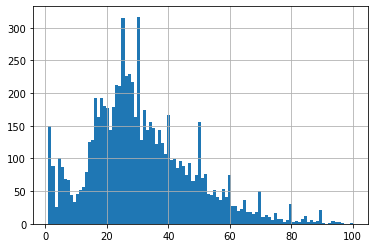

In [5]:
labels.real_age.hist(bins = 100)

Видно, что возраста распределены неравномерно. Следует ожидать, что обученная модель будет лучше распознавать людей 20-30 лет и хуже — старшей 50

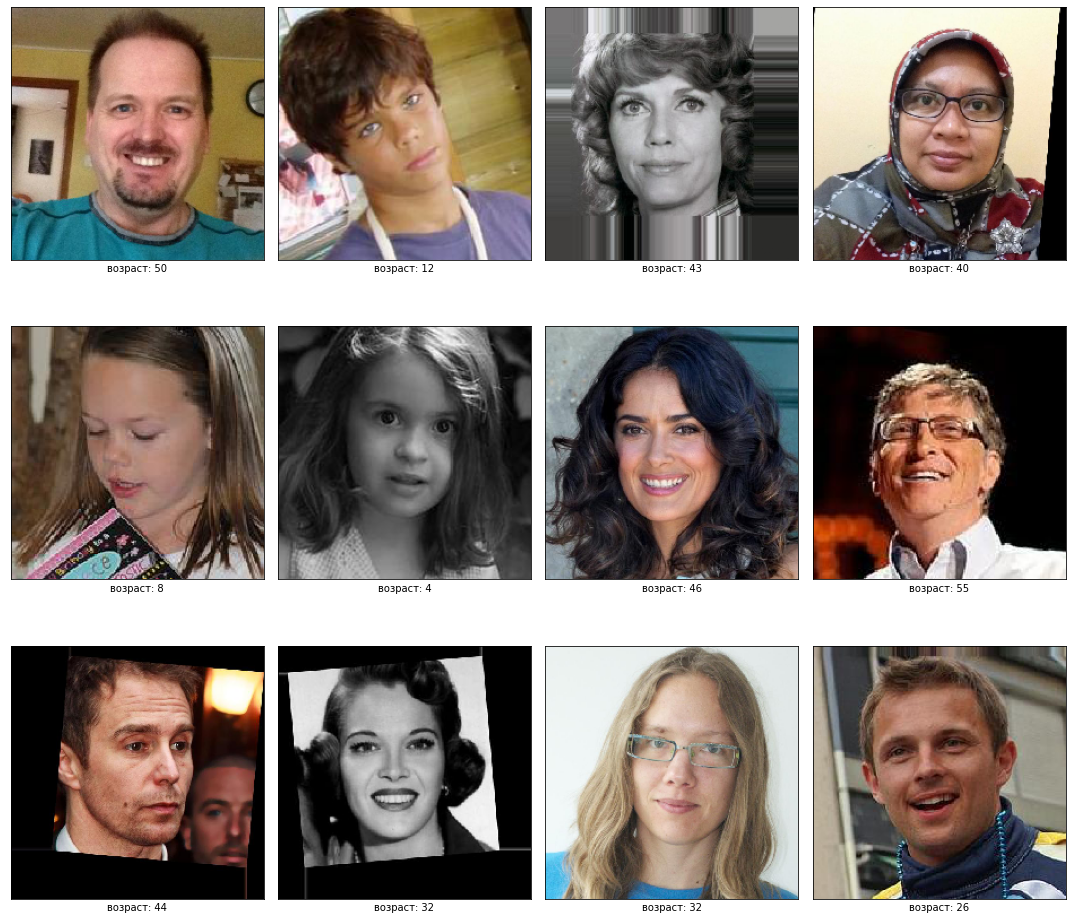

In [6]:
fig = plt.figure(figsize=(15,15))
for i in range(12):
    img, label = train_gen_flow.next()
    fig.add_subplot(3, 4, i+1)
    plt.imshow(img[i])
    plt.xlabel('возраст: '+str(label[i]))
    plt.xticks([])
    plt.yticks([])

    plt.tight_layout()

На первый взгляд разметка соотвествует действительности. 
Видно, что есть фотографии разного размера, повернутые, черно-белые, с искажениями. Ориентация у всех фотографий совпадает, перевернутых не обнаружено. Поэтому, вероятно отражать по вертикали не придется. 

## Обучение модели

```python КОД ОБУЧЕНИЯ МОДЕЛИ

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd



def load_train(path):   
    labels = pd.read_csv(path +'labels.csv') 
    train_datagen = ImageDataGenerator( validation_split=0.25,rescale=1/255,     
    horizontal_flip=True, 
    #vertical_flip=True, 
    rotation_range =90, 
    width_shift_range = 0.2,
    height_shift_range=0.2 )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        subset='training') 
    return train_datagen_flow

def load_test(path):   
    labels = pd.read_csv(path +'labels.csv') 
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345, subset='validation') 
 
    return test_datagen_flow



def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mean_absolute_error'])
    return model

    
def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, validation_data=test_data, batch_size=batch_size, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, verbose=2, shuffle=True)
    return model

```

Результат обучения модели:

```

2022-11-10 08:53:22.521832: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.6
2022-11-10 08:53:22.523968: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.6
2022-11-10 08:53:23.403050: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2022-11-10 08:53:23.412940: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-11-10 08:53:23.413008: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-11-10 08:53:23.413039: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-11-10 08:53:23.414947: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-11-10 08:53:23.415422: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-11-10 08:53:23.417830: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-11-10 08:53:23.419003: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-11-10 08:53:23.419057: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-11-10 08:53:23.424384: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
2022-11-10 08:53:23.631866: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2022-11-10 08:53:23.640774: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2100000000 Hz
2022-11-10 08:53:23.641355: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x4c40cb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-11-10 08:53:23.641387: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-11-10 08:53:23.801814: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x42a0fd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-10 08:53:23.801858: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2022-11-10 08:53:23.803729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1555] Found device 0 with properties: 
pciBusID: 0000:8b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-11-10 08:53:23.803794: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-11-10 08:53:23.803805: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-11-10 08:53:23.803838: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2022-11-10 08:53:23.803850: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10
2022-11-10 08:53:23.803862: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10
2022-11-10 08:53:23.803873: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusparse.so.10
2022-11-10 08:53:23.803882: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2022-11-10 08:53:23.807465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1697] Adding visible gpu devices: 0
2022-11-10 08:53:23.807533: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2022-11-10 08:53:24.332042: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1096] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-11-10 08:53:24.332094: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102]      0 
2022-11-10 08:53:24.332102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] 0:   N 
2022-11-10 08:53:24.335649: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-10 08:53:24.335701: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1241] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10240 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8b:00.0, compute capability: 7.0)
Downloading data from https://github.com/keras-team/keras-applications/releases/download/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

    8192/94765736 [..............................] - ETA: 1s
  262144/94765736 [..............................] - ETA: 20s
 1990656/94765736 [..............................] - ETA: 5s 
 8314880/94765736 [=>............................] - ETA: 1s
16310272/94765736 [====>.........................] - ETA: 1s
23502848/94765736 [======>.......................] - ETA: 0s
31326208/94765736 [========>.....................] - ETA: 0s
37814272/94765736 [==========>...................] - ETA: 0s
45334528/94765736 [=============>................] - ETA: 0s
53207040/94765736 [===============>..............] - ETA: 0s
60612608/94765736 [==================>...........] - ETA: 0s
68124672/94765736 [====================>.........] - ETA: 0s
75505664/94765736 [======================>.......] - ETA: 0s
82534400/94765736 [=========================>....] - ETA: 0s
89776128/94765736 [===========================>..] - ETA: 0s
94773248/94765736 [==============================] - 1s 0us/step
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/20
2022-11-10 08:53:37.925227: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-11-10 08:53:38.382781: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 106s - loss: 318.1216 - mean_absolute_error: 13.1583 - val_loss: 786.8099 - val_mean_absolute_error: 23.1303
Epoch 2/20
178/178 - 97s - loss: 144.1615 - mean_absolute_error: 9.1844 - val_loss: 814.6630 - val_mean_absolute_error: 23.6330
Epoch 3/20
178/178 - 98s - loss: 127.2439 - mean_absolute_error: 8.5867 - val_loss: 318.7876 - val_mean_absolute_error: 13.7661
Epoch 4/20
178/178 - 97s - loss: 112.1006 - mean_absolute_error: 8.0410 - val_loss: 164.3188 - val_mean_absolute_error: 9.6024
Epoch 5/20
178/178 - 96s - loss: 103.8658 - mean_absolute_error: 7.7170 - val_loss: 122.0650 - val_mean_absolute_error: 8.4057
Epoch 6/20
178/178 - 98s - loss: 99.1617 - mean_absolute_error: 7.5775 - val_loss: 134.0621 - val_mean_absolute_error: 8.9525
Epoch 7/20
178/178 - 99s - loss: 88.9706 - mean_absolute_error: 7.2159 - val_loss: 139.7873 - val_mean_absolute_error: 8.6894
Epoch 8/20
178/178 - 98s - loss: 85.0952 - mean_absolute_error: 6.9967 - val_loss: 110.7973 - val_mean_absolute_error: 8.2177
Epoch 9/20
178/178 - 99s - loss: 78.3081 - mean_absolute_error: 6.8127 - val_loss: 128.1565 - val_mean_absolute_error: 8.4455
Epoch 10/20
178/178 - 100s - loss: 77.3855 - mean_absolute_error: 6.6763 - val_loss: 96.1456 - val_mean_absolute_error: 7.5989
Epoch 11/20
178/178 - 94s - loss: 68.9419 - mean_absolute_error: 6.4029 - val_loss: 111.5951 - val_mean_absolute_error: 7.8017
Epoch 12/20
178/178 - 98s - loss: 66.4140 - mean_absolute_error: 6.2272 - val_loss: 109.2065 - val_mean_absolute_error: 7.8368
Epoch 13/20
178/178 - 98s - loss: 66.9108 - mean_absolute_error: 6.2340 - val_loss: 116.8678 - val_mean_absolute_error: 7.9692
Epoch 14/20
178/178 - 92s - loss: 61.2921 - mean_absolute_error: 6.0261 - val_loss: 132.6538 - val_mean_absolute_error: 8.5429
Epoch 15/20
178/178 - 96s - loss: 57.9814 - mean_absolute_error: 5.8773 - val_loss: 100.9787 - val_mean_absolute_error: 7.3702
Epoch 16/20
178/178 - 99s - loss: 57.7713 - mean_absolute_error: 5.8424 - val_loss: 94.1090 - val_mean_absolute_error: 7.1561
Epoch 17/20
178/178 - 97s - loss: 55.0220 - mean_absolute_error: 5.7001 - val_loss: 130.0101 - val_mean_absolute_error: 8.4933
Epoch 18/20
178/178 - 97s - loss: 51.4358 - mean_absolute_error: 5.5001 - val_loss: 131.3006 - val_mean_absolute_error: 8.3789
Epoch 19/20
178/178 - 98s - loss: 50.4504 - mean_absolute_error: 5.4764 - val_loss: 97.4873 - val_mean_absolute_error: 7.3892
Epoch 20/20
178/178 - 97s - loss: 47.7006 - mean_absolute_error: 5.3437 - val_loss: 97.7779 - val_mean_absolute_error: 7.3591
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 97.7779 - mean_absolute_error: 7.3591
Test MAE: 7.3591
```

## Анализ обученной модели

 - обучена модель ResNetc 50 слоями, предобученная на ImageNet
 - в качестве фнукции активации выбрана ReLu
 - Так как в изначальном датасете не так много изображений, была проведена аугментация
 - требуемая МАЕ была достигнута уже через 10 эпох
 - через 16 эпох достигнута MAE в 7,15
 - вероятно, можно улучшить модель и дальше, увеличивая число эпох, добавляя аугментацию и меняя другие параметры
 - ошибка в 7 лет позволит реализовать программу таргетированных предложений
 - однако для проверки возраста покупателей при продаже алкоголя такая модель вряд ли подойдет - слишком большая ошибка
